# Bioblitz 2025 analysis 

In [6]:
import os
os.getcwd()
os.chdir("..")

In [8]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import folium
from folium import plugins
data=pd.read_csv("Data/Bioblitz data/Bioblitz2025.csv")
data

,id,date,time,created,modified,species name,scientific name,family,species type,species group,...,notes,substrate,is certain,is escape,obscurity,embargo date,external reference,has photos,has sounds,link
0,347455098,2025-04-30,08:52:00,2025-04-30 08:52:41.658452,2025-04-30 08:52:44.280610,Red Campion,Silene dioica,Caryophyllaceae,species,Plants,...,NaN,NaN,True,False,0,NaN,NaN,True,False,https://waarneming.nl/observation/347455098/
1,347455234,2025-04-30,08:53:00,2025-04-30 08:53:26.341020,2025-04-30 08:53:28.835469,Cock's-foot,Dactylis glomerata,Poaceae,species,Plants,...,NaN,NaN,True,False,0,NaN,NaN,True,False,https://waarneming.nl/observation/347455234/
2,347463558,2025-04-30,09:09:00,2025-04-30 09:46:29.165578,2025-04-30 09:46:31.162844,Black Redstart,Phoenicurus ochruros,"Chats, Old World Flycatchers (Muscicapidae)",species,Birds,...,NaN,NaN,True,False,0,NaN,NaN,False,False,https://waarneming.nl/observation/347463558/
3,347476331,2025-04-30,11:02:00,2025-04-30 11:03:03.371791,2025-04-30 11:03:06.174183,Alder Fly,Sialis lutaria,Sialidae (Alderflies),species,Insects (other),...,NaN,NaN,True,False,0,NaN,NaN,True,False,https://waarneming.nl/observation/347476331/
4,347481237,2025-04-30,11:31:00,2025-04-30 11:31:43.407263,2025-05-14 20:23:55.769433,Tipula maxima,Tipula maxima,Tipulidae (Crane flies),species,Flies (Diptera),...,NaN,NaN,True,False,0,NaN,NaN,True,False,https://waarneming.nl/observation/347481237/
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9833,371339519,2025-06-19,13:21:00,2025-09-01 18:58:15.192422,2025-09-01 18:58:16.592856,Common Buzzard,Buteo buteo,"Kites, Hawks, Eagles (Accipitridae)",species,Birds,...,NaN,NaN,True,False,0,NaN,NaN,False,False,https://waarneming.nl/observation/371339519/
9834,372421209,2025-06-12,11:48:00,2025-09-10 22:23:52.956335,2025-09-10 22:34:32.962512,Small-notched Mason Wasp,Ancistrocerus gazella,Vespidae,species,"Bees, Wasps and Ants (Hymenoptera)",...,Geparasiteerd door Pseudoxenos schaumi,NaN,True,False,0,NaN,NaN,True,False,https://waarneming.nl/observation/372421209/
9835,372421778,2025-06-12,11:48:00,2025-09-10 22:31:56.248922,2025-09-10 22:33:00.728029,Pseudoxenos schaumi,Pseudoxenos schaumi,Xenidae,species,Insects (other),...,NaN,NaN,True,False,0,NaN,NaN,True,False,https://waarneming.nl/observation/372421778/
9836,372433297,2025-06-12,11:48:00,2025-09-11 09:04:15.264834,2025-09-11 09:04:15.264847,Pseudoxenos schaumi,Pseudoxenos schaumi,Xenidae,species,Insects (other),...,NaN,NaN,True,False,0,NaN,NaN,False,False,https://waarneming.nl/observation/372433297/


In [9]:
# summary of data
df=data[["species group", "number", "lat", "lng"]]
df
df_filtrato = df[df["species group"] == "Plants"]
df_filtrato


# Filtra i valori di lat e lng fuori dai limiti
df_filtrato = df_filtrato[
    (df_filtrato["lat"].between(51.5, 52.4)) &
    (df_filtrato["lng"].between(5.2, 5.8))
].copy()
df_filtrato


,species group,number,lat,lng
0,Plants,1,51.987704,5.668764
1,Plants,1,51.987564,5.668536
9,Plants,1,51.982371,5.656390
10,Plants,1,51.982265,5.656453
14,Plants,1,51.983128,5.663561
...,...,...,...,...
9796,Plants,1,51.988524,5.667894
9797,Plants,1,51.988454,5.667837
9806,Plants,1,51.986231,5.668639
9826,Plants,1,51.980871,5.656022


In [10]:
# 1. (opzionale) vedere se ci sono duplicati lat/lng
duplicati = df_filtrato.duplicated(subset=["lat", "lng"], keep=False)
df_duplicati = df_filtrato[duplicati]

print("Colonne di df_filtrato:", df_filtrato.columns.tolist())

# 2. Raggruppare per lat/lng e sommare 'number'
df_raggruppato = (
    df_filtrato
    .groupby(["lat", "lng"], as_index=False)
    .agg({
        "species group": "first",   # tieni il primo valore, se ti serve
        "number": "sum"             # somma le unità in quella coordinata
    })
)

# Se 'species group' non ti serve più, lo togli
df_raggruppato = df_raggruppato.drop(columns=["species group"])

# 3. KMeans sui punti (lat, lng) raggruppati
X = df_raggruppato[["lat", "lng"]]

kmeans = KMeans(
    n_clusters=98,   # cambia se vuoi un altro numero di cluster
    random_state=42,
    n_init=10
)

df_raggruppato["cluster"] = kmeans.fit_predict(X)

# 4. Centroidi delle coordinate dal modello
centroids = pd.DataFrame(
    kmeans.cluster_centers_,
    columns=["lat_centroid", "lng_centroid"]
)

# 5. SOMMA di `number` per cluster (sulle unità assegnate)
cluster_number_sum = (
    df_raggruppato
    .groupby("cluster")["number"]
    .sum()
    .reset_index(name="number_sum")
)

# 6. Unisco centroidi e somma per cluster
#    (gli indici 0..n_clusters-1 coincidono con i valori di 'cluster')
result = centroids.join(
    cluster_number_sum.set_index("cluster"),
    how="left"
)

# Se vuoi number_sum come intero:
result["number_sum"] = result["number_sum"].astype(int)

max(result["number_sum"])
min(result["number_sum"])
len(result["number_sum"])
result["number_sum"]=result["number_sum"]/22.6
result["number_sum"]=result["number_sum"].round(0)
result["number_sum"]


# 7. Salva il risultato finale: un record per cluster
result.to_csv("Bioblitz2025Cluster.csv", index=False)



Colonne di df_filtrato: ['species group', 'number', 'lat', 'lng']


In [11]:
df_raggruppato

,lat,lng,number,cluster
0,51.979684,5.673998,1,84
1,51.980237,5.672761,1,84
2,51.980269,5.672776,1,84
3,51.980762,5.672781,1,84
4,51.980801,5.666695,10,79
...,...,...,...,...
2795,51.993134,5.663637,1,6
2796,51.993358,5.664844,2,54
2797,51.994270,5.667312,1,26
2798,51.994290,5.667263,1,26


In [12]:
# --- Usa il tuo dataframe dei centroidi ---
dfc = result.copy()

# Se serve, rinomino per comodità
dfc = dfc.rename(columns={
    "lat_centroid": "lat",
    "lng_centroid": "lng",
    "number_mean": "number"
})

# 1) Pulizia base (nel dubbio)
dfc["lat"] = pd.to_numeric(dfc["lat"], errors="coerce")
dfc["lng"] = pd.to_numeric(dfc["lng"], errors="coerce")
dfc["number_sum"] = pd.to_numeric(dfc["number_sum"], errors="coerce")
dfc = dfc.replace([np.inf, -np.inf], np.nan).dropna(subset=["lat", "lng", "number_sum"])
if dfc.empty:
    raise ValueError("Nessun centroide valido.")

# 2) Centro mappa
center = [float(dfc["lat"].mean()), float(dfc["lng"].mean())]

# 3) Mappa con più basemap
m = folium.Map(location=center, zoom_start=15, tiles=None)

folium.TileLayer("CartoDB positron", name="Chiara (Positron)").add_to(m)
folium.TileLayer("CartoDB dark_matter", name="Scura (Dark Matter)").add_to(m)
folium.TileLayer("OpenStreetMap", name="OpenStreetMap").add_to(m)
folium.TileLayer(
    tiles="https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}",
    attr="Esri",
    name="Satellite (Esri)"
).add_to(m)

# 4) Layer CENTROIDI (dimensione in base a number)
centroids_fg = folium.FeatureGroup(name="Centroidi (cluster)", show=True)

# scala raggio in modo proporzionale ma ragionevole
min_n = dfc["number_sum"].min()
max_n = dfc["number_sum"].max()
rng = max(max_n - min_n, 1)

for _, r in dfc.iterrows():
    # raggio tra 4 e 15
    radius = 4 + 11 * ( (r["number_sum"] - min_n) / rng )

    popup_txt = (
        f"<b>Cluster</b>: {int(_)}"
        f"<br><b>Lat</b>: {r['lat']:.6f}"
        f"<br><b>Lng</b>: {r['lng']:.6f}"
        f"<br><b>Number medio</b>: {r['number_sum']}"
    )

    folium.CircleMarker(
        location=[float(r["lat"]), float(r["lng"])],
        radius=radius,
        color="#1f77b4",
        fill=True,
        fill_opacity=0.8,
        popup=popup_txt
    ).add_to(centroids_fg)

centroids_fg.add_to(m)

# 5) Heatmap pesata dal number (opzionale)
heat_data = dfc[["lat", "lng", "number_sum"]].values.tolist()
plugins.HeatMap(
    heat_data,
    radius=25,
    blur=20,
    max_zoom=17,
    name="HeatMap centroidi (pesata)",
    show=False
).add_to(m)

# 6) Controllo layer + salvataggio
folium.LayerControl().add_to(m)
m.save("mappa_centroidi.html")
print("Mappa salvata come mappa_centroidi.html")


Mappa salvata come mappa_centroidi.html


In [13]:
clusterbioblitz2025=pd.read_csv("Bioblitz2025Cluster.csv")
# clusterbioblitz2025=clusterbioblitz2025.iloc[:,1:]
clusterscientific2025=pd.read_csv("../Scientific Analysis 2025/DataAfterCluster.csv")
clusterscientific2025=clusterscientific2025.iloc[:,1:]
clusterbioblitz2025
# clusterscientific2025



,lat_centroid,lng_centroid,number_sum
0,51.986311,5.669275,1.0
1,51.983957,5.660513,1.0
2,51.985368,5.666730,2.0
3,51.988325,5.665872,3.0
4,51.986109,5.672601,3.0
...,...,...,...
93,51.981177,5.671974,1.0
94,51.992307,5.660211,0.0
95,51.990503,5.666677,0.0
96,51.984284,5.669086,0.0


In [14]:
R = 6371  # km
# Spatial distamce between centroids(Haversine)

dlat = np.radians(clusterbioblitz2025["lat_centroid"] - clusterscientific2025["lat"])
dlat
lat2=clusterbioblitz2025["lat_centroid"]
lat1=clusterscientific2025["lat"]
dlon = np.radians(clusterbioblitz2025["lng_centroid"] - clusterscientific2025["long"])

a = np.sin(dlat / 2)**2 + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlon / 2)**2
a
d_centroidi = 2 * R * np.arcsin(np.sqrt(a))

mean_value_1=clusterscientific2025["media"]
mean_value_2=clusterbioblitz2025["number_sum"]

d_valore = abs(mean_value_1 - mean_value_2)

w_space=0.2
w_value=0.8


value = (
    w_space * (d_centroidi / d_centroidi.max()) +
    w_value * (d_valore / d_valore.max())
)

value.mean()

np.float64(0.43716981422193846)

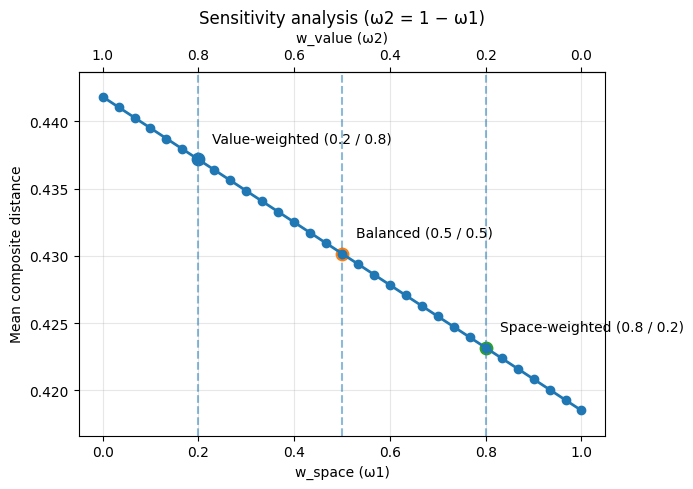

In [15]:
# --- normalize once ---
d_centroid_norm = d_centroidi / d_centroidi.max()
d_valore_norm   = d_valore   / d_valore.max()

# sweep weights 
w_space_vals = np.linspace(0, 1, 31)  # 0.0, 0.05, ..., 1.0
mean_scores = []

for w_space in w_space_vals:
    w_value = 1.0 - w_space
    composite = w_space * d_centroid_norm + w_value * d_valore_norm
    mean_scores.append(np.mean(composite))

mean_scores = np.array(mean_scores)

# --- plot ---
fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(w_space_vals, mean_scores, marker="o", linewidth=2)

ax.set_xlabel("w_space (ω1)")
ax.set_ylabel("Mean composite distance")
ax.set_title("Sensitivity analysis (ω2 = 1 − ω1)")
ax.grid(True, alpha=0.3)

# tighten y-limits a bit for visual contrast
ymin, ymax = mean_scores.min(), mean_scores.max()
pad = 0.08 * (ymax - ymin) if ymax > ymin else 0.01
ax.set_ylim(ymin - pad, ymax + pad)

# mark the three scenarios
scenarios = [
    (0.2, "Value-weighted (0.2 / 0.8)"),
    (0.5, "Balanced (0.5 / 0.5)"),
    (0.8, "Space-weighted (0.8 / 0.2)"),
]

for ws, label in scenarios:
    idx = np.argmin(np.abs(w_space_vals - ws))
    x = w_space_vals[idx]
    y = mean_scores[idx]
    ax.axvline(x, linestyle="--", alpha=0.5)
    ax.scatter([x], [y], s=80)
    ax.annotate(
        label,
        xy=(x, y),
        xytext=(10, 10),
        textcoords="offset points",
        ha="left",
        va="bottom"
    )

# secondary x-axis for w_value
secax = ax.secondary_xaxis('top', functions=(lambda x: 1-x, lambda x: 1-x))
secax.set_xlabel("w_value (ω2)")

plt.tight_layout()
plt.show()


In [16]:
R = 6371

dlat = np.radians(clusterbioblitz2025["lat_centroid"] - clusterscientific2025["lat"])
dlon = np.radians(clusterbioblitz2025["lng_centroid"] - clusterscientific2025["long"])

lat1 = np.radians(clusterscientific2025["lat"])
lat2 = np.radians(clusterbioblitz2025["lat_centroid"])

a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
d_centroidi = 2 * R * np.arcsin(np.sqrt(a)) 

D0 = 0.1

d_norm = np.minimum(d_centroidi / D0, 1)   

mean_value_1 = clusterscientific2025["media"]
mean_value_2 = clusterbioblitz2025["number_sum"]

d_valore = abs(mean_value_1 - mean_value_2)

# pesi
w_space = 0.8
w_value = 0.2

value = (
    w_space * d_norm +
    w_value * d_valore
)

value.mean()


np.float64(1.6811999392536239)

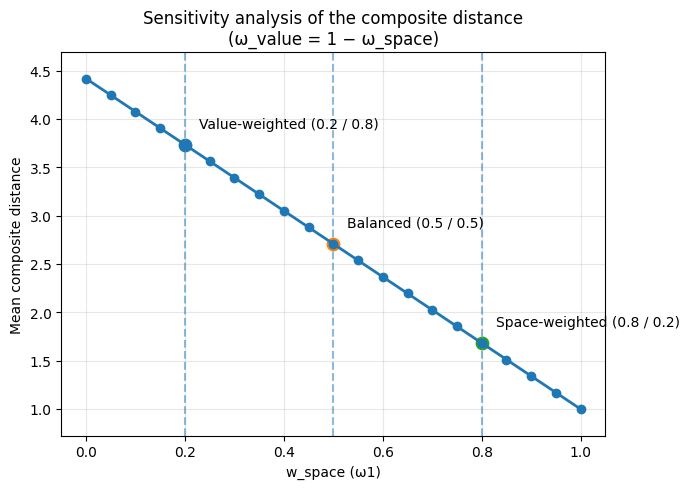

In [17]:
w_space_vals = np.linspace(0, 1, 21)
mean_scores = []

for w_space in w_space_vals:
    w_value = 1.0 - w_space

    composite = (
        w_space * d_norm +
        w_value * d_valore
    )

    mean_scores.append(composite.mean())

mean_scores = np.array(mean_scores)

plt.figure(figsize=(7, 5))
plt.plot(w_space_vals, mean_scores, marker="o", linewidth=2)

plt.xlabel("w_space (ω1)")
plt.ylabel("Mean composite distance")
plt.title("Sensitivity analysis of the composite distance\n(ω_value = 1 − ω_space)")
plt.grid(True, alpha=0.3)

ymin, ymax = mean_scores.min(), mean_scores.max()
pad = 0.08 * (ymax - ymin) if ymax > ymin else 0.01
plt.ylim(ymin - pad, ymax + pad)

scenarios = [
    (0.2, "Value-weighted (0.2 / 0.8)"),
    (0.5, "Balanced (0.5 / 0.5)"),
    (0.8, "Space-weighted (0.8 / 0.2)")
]

for ws, label in scenarios:
    idx = np.argmin(np.abs(w_space_vals - ws))
    x = w_space_vals[idx]
    y = mean_scores[idx]
    plt.axvline(x, linestyle="--", alpha=0.5)
    plt.scatter([x], [y], s=80)
    plt.annotate(
        label,
        xy=(x, y),
        xytext=(10, 10),
        textcoords="offset points",
        ha="left",
        va="bottom"
    )

plt.tight_layout()
plt.show()
